# Fraud Detection: Car Insurance Claims
#### 4IZ566 Assignment 1 | ZS 2021/22 

Dataset představuje záznamy o hlášených pojistných událostech u belgické pojišťovny (pojištěnci jsou fyzické osoby). Cílovou proměnnou (target label) je `fraud` a může nabývat hodnot `Y`/ `N` vyjadřujících, jestli se jednalo o podvodné (fraudulent - Y) hlášení nebo ne. Jedná se tedy o binární klasifikační úlohu.

Podrobný popis jednotlivých features dostupný zde http://seppe.net/aa/assignment1/#data

Vzhledem k četnosti zastoupení cílových tříd se jedná o imbalanced klasifikaci, bylo tedy zapotřebí použít metody balancování trénovacího datasetu. Použity byly metody SMOTE a undersampling. Pro názornost je 1. model Logistic Regression bez použití vyvažování. V takovém případě je možné vidět, že TP (positive = fraud) má velice nízké zastoupení, i přesto Accuracy je 0.99. Protože pro pojišťovnu je přednější a i levnější podezřelá hlášení odhalit, než neodhalit, klíčovou evaluační metrikou tak v tomto případě je recall. Sledovány jsou také ROC curve a AUC.

Dataset je nejprve rozdělen na evaluační hold-out set a development set. Na evaluačním setu byla na závěr jednorázově provedena finální evaluace modelu, slouží tedy jako evaluation on unseen data. 

Development set je rozdělen na train set a test set. Train set slouží k vytvoření modelů, které jsou následně laděny na test setu.

#### Struktura řešení:
1. Import packages, rozdělení development x evaluation (hold-out) set
2. EDA
3. Data preprocessing & Feature engineering
4. Model building & tuning
5. Evaluation (unseen data)

## Import packages

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline

pd.set_option("display.max_columns",500)
pd.set_option('display.max_rows', 500)
plt.style.use('ggplot')

In [3]:
data_path = r"./train.csv"

In [4]:
df_all = pd.read_csv(data_path, sep=";", encoding="utf-8-sig")

#### Oddělení hold out test setu pro finální evaluaci od development setu

In [5]:
df = df_all.sample(frac=0.8,random_state=42)
eval_set = df_all.drop(df.index)

# Exploratory Data Analysis (EDA)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44370 entries, 31604 to 46647
Data columns (total 78 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   claim_id                    44370 non-null  int64  
 1   fraud                       44370 non-null  object 
 2   claim_amount                44370 non-null  object 
 3   claim_date_registered       44370 non-null  int64  
 4   claim_date_occured          44370 non-null  int64  
 5   claim_time_occured          5176 non-null   float64
 6   claim_postal_code           44370 non-null  int64  
 7   claim_cause                 44370 non-null  object 
 8   claim_liable                44370 non-null  object 
 9   claim_num_injured           44370 non-null  int64  
 10  claim_num_third_parties     44370 non-null  int64  
 11  claim_num_vehicles          44370 non-null  int64  
 12  claim_police                44370 non-null  object 
 13  claim_alcohol              

In [7]:
# check imbalance
df["fraud"].replace({"N":0, "Y":1}).sum() / len(df["fraud"]) * 100

0.5611899932386748

#### pouze 0.56% případů bylo podvodných, jedná se tedy o velmi nevyvážený (imbalanced) dataset

Zastoupení značek aut v target labelu

In [8]:
pd.crosstab(df["fraud"], df["claim_vehicle_brand"], normalize=True)

claim_vehicle_brand,ALFA ROMEO,AUDI,BMW,CHEVROLET,CHRYSLER,CITROEN,DACIA,DODGE,FIAT,FORD,HONDA,HYUNDAI,IVECO,JAGUAR,JEEP,KIA,LANCIA,LAND ROVER,MAZDA,MERCEDES,MINI,MITSUBISHI,NISSAN,OPEL,PEUGEOT,PORSCHE,RENAULT,SAAB,SEAT,SKODA,SSANGYONG,SUZUKI,TOYOTA,VOLKSWAGEN,VOLVO
fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
N,0.006881,0.045703,0.053653,0.008115,0.001672,0.082851,0.019109,0.001727,0.028485,0.081700,0.008444,0.024345,0.002056,0.001645,0.001426,0.019054,0.002522,0.004112,0.011816,0.050418,0.006799,0.008855,0.029143,0.104620,0.084825,0.001700,0.077258,0.002358,0.019959,0.020425,0.001453,0.010966,0.044716,0.105634,0.019685
Y,0.000055,0.000329,0.000713,0.000027,0.000000,0.000521,0.000219,0.000000,0.000302,0.000329,0.000000,0.000164,0.000000,0.000000,0.000027,0.000164,0.000000,0.000027,0.000055,0.000411,0.000137,0.000027,0.000137,0.000384,0.000356,0.000027,0.000384,0.000000,0.000055,0.000082,0.000000,0.000055,0.000137,0.000658,0.000082


Histogram hlášení v letech

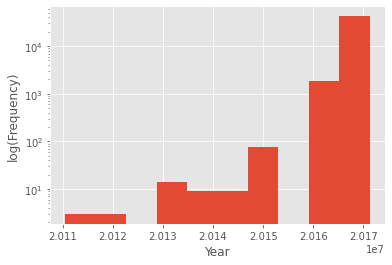

In [9]:
df["claim_date_occured"].plot(kind='hist', logy=True)
plt.ylabel('log(Frequency)')
plt.xlabel('Year')
plt.show()

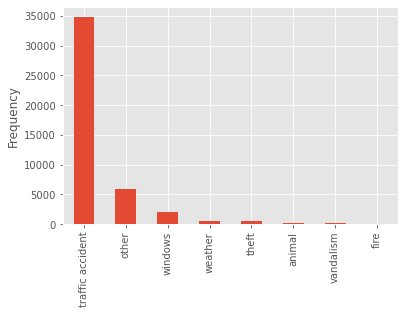

In [10]:
df["claim_cause"].value_counts().plot(kind='bar')
plt.ylabel("Frequency")
plt.show()

histogram pro jednotlivé features 

claim_id


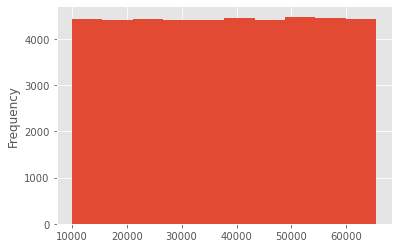

count    44370.000000
mean     37786.151273
std      16017.598402
min      10000.000000
25%      23911.250000
50%      37841.500000
75%      51653.750000
max      65468.000000
Name: claim_id, dtype: float64
*************************************************************************
fraud


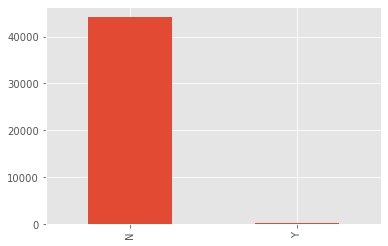

count     44370
unique        2
top           N
freq      44121
Name: fraud, dtype: object
*************************************************************************
claim_amount
******* too many values to plot *******************
count       44370
unique      39803
top       1447,00
freq           18
Name: claim_amount, dtype: object
*************************************************************************
claim_date_registered


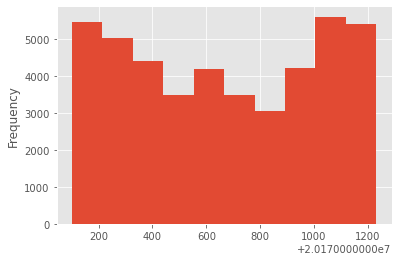

count    4.437000e+04
mean     2.017067e+07
std      3.459202e+02
min      2.017010e+07
25%      2.017040e+07
50%      2.017063e+07
75%      2.017100e+07
max      2.017123e+07
Name: claim_date_registered, dtype: float64
*************************************************************************
claim_date_occured


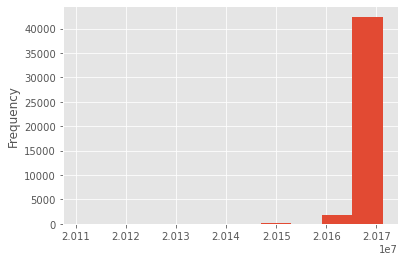

count    4.437000e+04
mean     2.017019e+07
std      2.375136e+03
min      2.011051e+07
25%      2.017032e+07
50%      2.017061e+07
75%      2.017092e+07
max      2.017123e+07
Name: claim_date_occured, dtype: float64
*************************************************************************
claim_time_occured


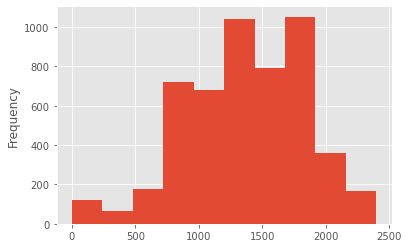

count    5176.000000
mean     1358.342349
std       470.356464
min         0.000000
25%      1000.000000
50%      1400.000000
75%      1730.000000
max      2400.000000
Name: claim_time_occured, dtype: float64
*************************************************************************
claim_postal_code


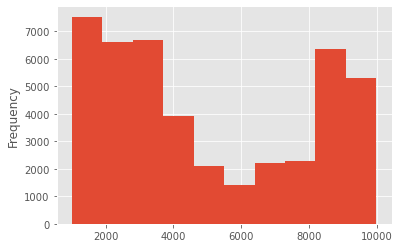

count    44370.000000
mean      4940.097836
std       2984.884210
min       1000.000000
25%       2300.000000
50%       3950.000000
75%       8400.000000
max       9991.000000
Name: claim_postal_code, dtype: float64
*************************************************************************
claim_cause


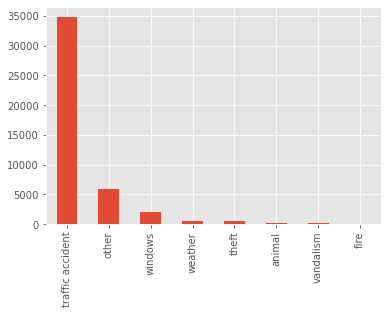

count                44370
unique                   8
top       traffic accident
freq                 34797
Name: claim_cause, dtype: object
*************************************************************************
claim_liable


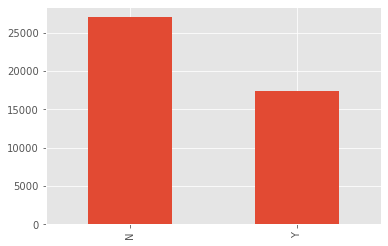

count     44370
unique        2
top           N
freq      27014
Name: claim_liable, dtype: object
*************************************************************************
claim_num_injured


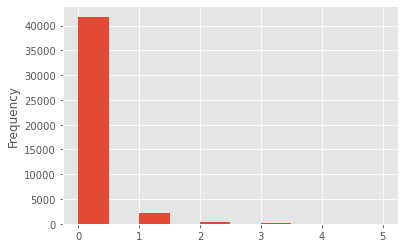

count    44370.000000
mean         0.071332
std          0.314310
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: claim_num_injured, dtype: float64
*************************************************************************
claim_num_third_parties


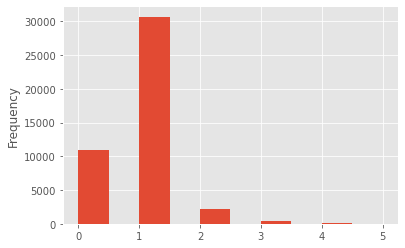

count    44370.000000
mean         0.831575
std          0.579157
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: claim_num_third_parties, dtype: float64
*************************************************************************
claim_num_vehicles


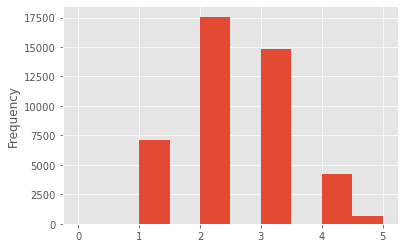

count    44370.000000
mean         2.407595
std          0.917372
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: claim_num_vehicles, dtype: float64
*************************************************************************
claim_police


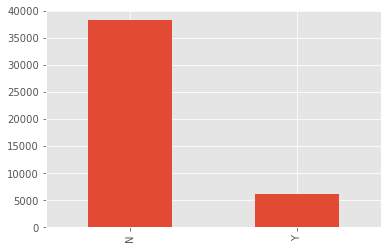

count     44370
unique        2
top           N
freq      38266
Name: claim_police, dtype: object
*************************************************************************
claim_alcohol


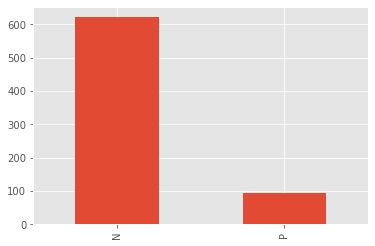

count     716
unique      2
top         N
freq      621
Name: claim_alcohol, dtype: object
*************************************************************************
claim_language


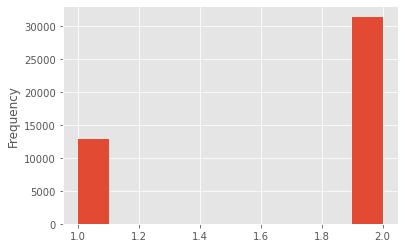

count    44339.000000
mean         1.708383
std          0.454512
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: claim_language, dtype: float64
*************************************************************************
claim_vehicle_id
******* too many values to plot *******************
count                                           36158
unique                                          33141
top       ZmM5NmZhZWYxM2MxNjAzMDM2NjNkMDkxMWJjY2U1ODU
freq                                                5
Name: claim_vehicle_id, dtype: object
*************************************************************************
claim_vehicle_brand
******* too many values to plot *******************
count          36475
unique            35
top       VOLKSWAGEN
freq            3877
Name: claim_vehicle_brand, dtype: object
*************************************************************************
claim_vehicle_type


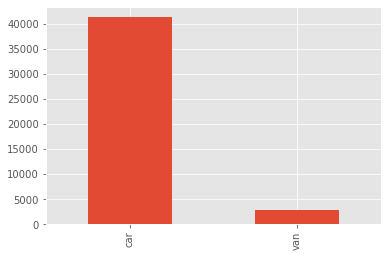

count     44249
unique        2
top         car
freq      41281
Name: claim_vehicle_type, dtype: object
*************************************************************************
claim_vehicle_date_inuse


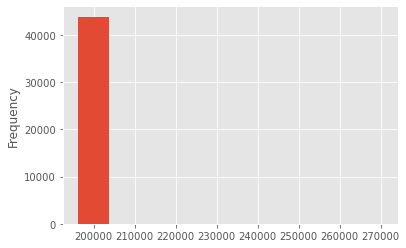

count     43885.000000
mean     200885.887661
std         604.004887
min      196204.000000
25%      200604.000000
50%      201006.000000
75%      201303.000000
max      270505.000000
Name: claim_vehicle_date_inuse, dtype: float64
*************************************************************************
claim_vehicle_cyl


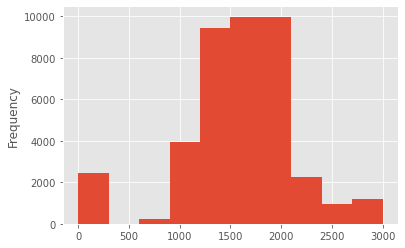

count    40457.000000
mean      1581.137801
std        566.391956
min          0.000000
25%       1360.000000
50%       1590.000000
75%       1968.000000
max       3000.000000
Name: claim_vehicle_cyl, dtype: float64
*************************************************************************
claim_vehicle_load


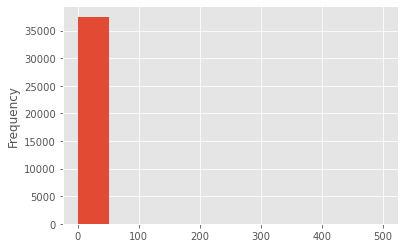

count    37524.000000
mean         1.928573
std          2.609099
min          0.600000
25%          1.610000
50%          1.850000
75%          2.070000
max        500.000000
Name: claim_vehicle_load, dtype: float64
*************************************************************************
claim_vehicle_fuel_type


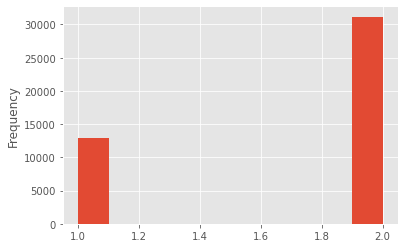

count    44025.000000
mean         1.708007
std          0.454684
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: claim_vehicle_fuel_type, dtype: float64
*************************************************************************
claim_vehicle_power


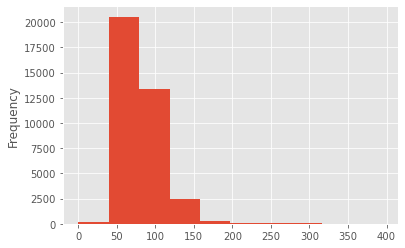

count    37088.000000
mean        78.685289
std         27.917045
min          0.000000
25%         59.000000
50%         77.000000
75%         91.000000
max        395.000000
Name: claim_vehicle_power, dtype: float64
*************************************************************************
policy_holder_id
******* too many values to plot *******************
count                                           44370
unique                                          24478
top       MTNlMmVhMzM4ZWMzNDIyMTY2OTJhN2EwY2E1YmI2N2I
freq                                               97
Name: policy_holder_id, dtype: object
*************************************************************************
policy_holder_postal_code


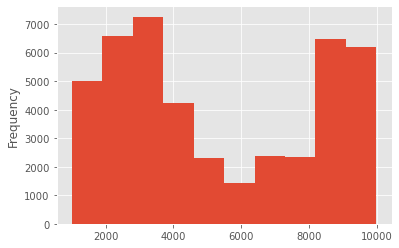

count    44282.000000
mean      5250.492638
std       2910.007252
min       1000.000000
25%       2620.000000
50%       4287.000000
75%       8500.000000
max       9992.000000
Name: policy_holder_postal_code, dtype: float64
*************************************************************************
policy_holder_form


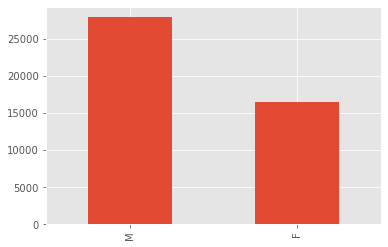

count     44370
unique        2
top           M
freq      27929
Name: policy_holder_form, dtype: object
*************************************************************************
policy_holder_year_birth


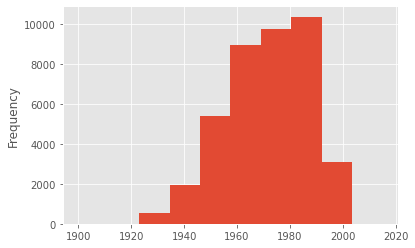

count    40103.000000
mean      1971.242176
std         15.491605
min       1900.000000
25%       1960.000000
50%       1972.000000
75%       1984.000000
max       2015.000000
Name: policy_holder_year_birth, dtype: float64
*************************************************************************
policy_holder_country


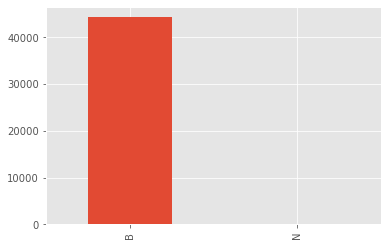

count     44370
unique        2
top           B
freq      44282
Name: policy_holder_country, dtype: object
*************************************************************************
policy_holder_expert_id
******* too many values to plot *******************
count                                            7638
unique                                             71
top       YmNkZjNiZTQ1MmYzNGQ5YTRmNjI0N2U1YzdiOWUzYzE
freq                                             1066
Name: policy_holder_expert_id, dtype: object
*************************************************************************
driver_id
******* too many values to plot *******************
count                                           44370
unique                                          23079
top       ZDEyMDQzM2I3MDE5MWMyODgwNThmNDkyZDczMjQ1ZGY
freq                                              353
Name: driver_id, dtype: object
*************************************************************************
driver_postal_code


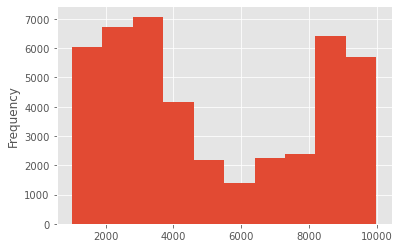

count    44313.000000
mean      5097.180376
std       2936.740664
min       1000.000000
25%       2490.000000
50%       4020.000000
75%       8450.000000
max       9992.000000
Name: driver_postal_code, dtype: float64
*************************************************************************
driver_form


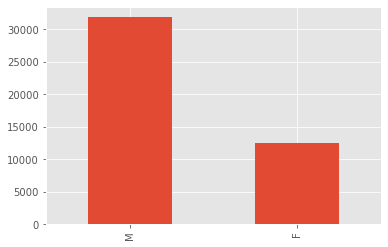

count     44370
unique        2
top           M
freq      31869
Name: driver_form, dtype: object
*************************************************************************
driver_year_birth


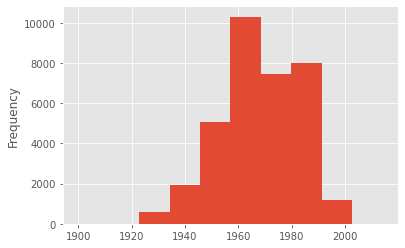

count    34544.000000
mean      1967.908986
std         14.874011
min       1900.000000
25%       1958.000000
50%       1968.000000
75%       1980.000000
max       2014.000000
Name: driver_year_birth, dtype: float64
*************************************************************************
driver_country


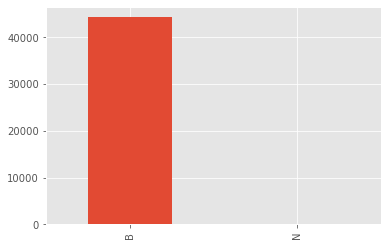

count     44370
unique        2
top           B
freq      44313
Name: driver_country, dtype: object
*************************************************************************
driver_expert_id
******* too many values to plot *******************
count                                           10975
unique                                             72
top       YmNkZjNiZTQ1MmYzNGQ5YTRmNjI0N2U1YzdiOWUzYzE
freq                                             1490
Name: driver_expert_id, dtype: object
*************************************************************************
driver_injured


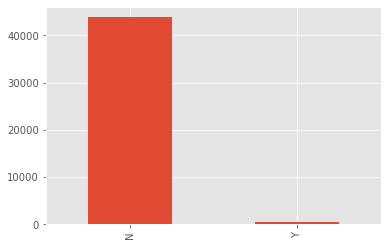

count     44370
unique        2
top           N
freq      43854
Name: driver_injured, dtype: object
*************************************************************************
driver_vehicle_id
******* too many values to plot *******************
count                                           36166
unique                                          33148
top       OGJhN2MzY2I4YmU4ZGRjNTU0ZTk3YjQwMDA2M2IxMmQ
freq                                                5
Name: driver_vehicle_id, dtype: object
*************************************************************************
third_party_1_id
******* too many values to plot *******************
count                                           33414
unique                                          23904
top       NTg0ODNiYTYwODI0MGU0MzRlODM2MGNkYWI5NGNkODY
freq                                              101
Name: third_party_1_id, dtype: object
*************************************************************************
third_party_1_postal_code


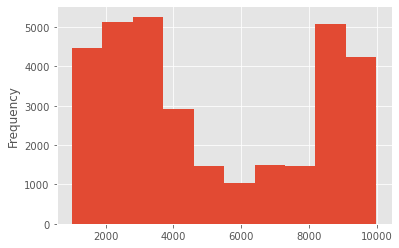

count    32545.000000
mean      5098.488954
std       2976.298610
min       1000.000000
25%       2450.000000
50%       4000.000000
75%       8500.000000
max       9992.000000
Name: third_party_1_postal_code, dtype: float64
*************************************************************************
third_party_1_injured


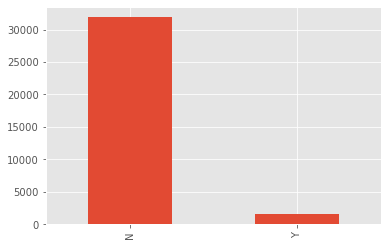

count     33414
unique        2
top           N
freq      31900
Name: third_party_1_injured, dtype: object
*************************************************************************
third_party_1_vehicle_type


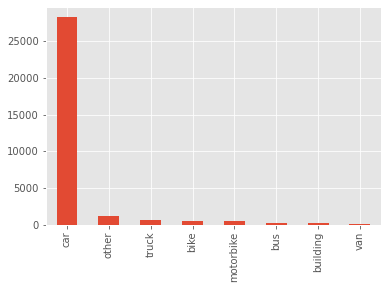

count     31580
unique        8
top         car
freq      28235
Name: third_party_1_vehicle_type, dtype: object
*************************************************************************
third_party_1_form


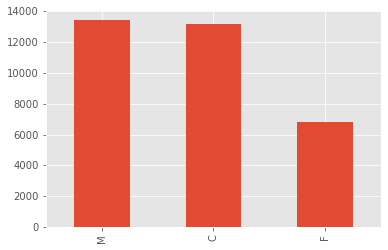

count     33414
unique        3
top           M
freq      13423
Name: third_party_1_form, dtype: object
*************************************************************************
third_party_1_year_birth


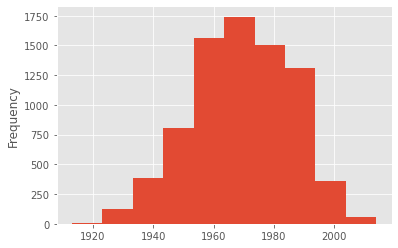

count    7862.000000
mean     1969.150852
std        16.253373
min      1913.000000
25%      1958.000000
50%      1969.000000
75%      1982.000000
max      2014.000000
Name: third_party_1_year_birth, dtype: float64
*************************************************************************
third_party_1_country


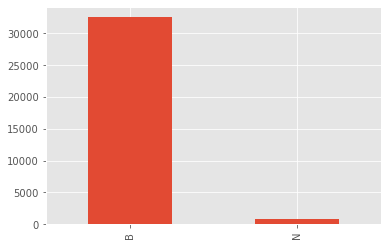

count     33414
unique        2
top           B
freq      32545
Name: third_party_1_country, dtype: object
*************************************************************************
third_party_1_vehicle_id
******* too many values to plot *******************
count                                           29295
unique                                          28654
top       NTA1OGYxYWY4Mzg4NjMzZjYwOWNhZGI3NWE3NWRjOWQ
freq                                              122
Name: third_party_1_vehicle_id, dtype: object
*************************************************************************
third_party_1_expert_id
******* too many values to plot *******************
count                                             511
unique                                             66
top       YmNkZjNiZTQ1MmYzNGQ5YTRmNjI0N2U1YzdiOWUzYzE
freq                                               53
Name: third_party_1_expert_id, dtype: object
*********************************************************************

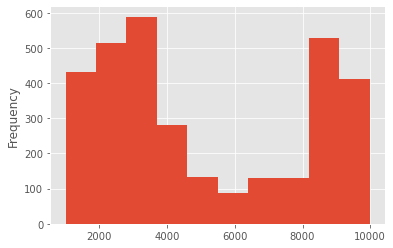

count    3236.000000
mean     5065.176143
std      2978.811177
min      1000.000000
25%      2480.000000
50%      3920.000000
75%      8530.000000
max      9991.000000
Name: third_party_2_postal_code, dtype: float64
*************************************************************************
third_party_2_injured


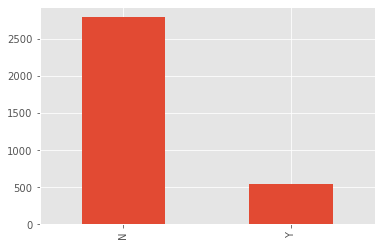

count     3335
unique       2
top          N
freq      2794
Name: third_party_2_injured, dtype: object
*************************************************************************
third_party_2_vehicle_type


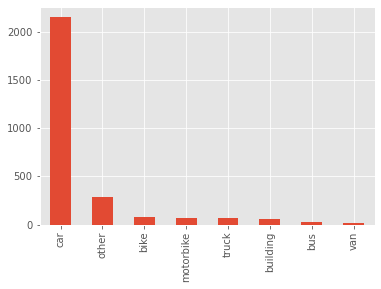

count     2731
unique       8
top        car
freq      2147
Name: third_party_2_vehicle_type, dtype: object
*************************************************************************
third_party_2_form


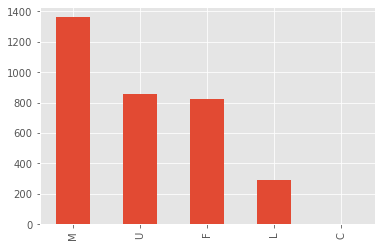

count     3335
unique       5
top          M
freq      1362
Name: third_party_2_form, dtype: object
*************************************************************************
third_party_2_year_birth


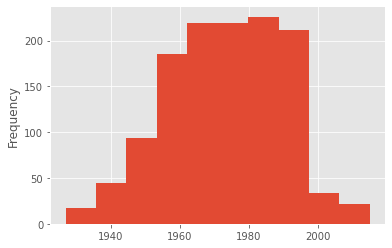

count    1271.000000
mean     1973.277734
std        16.582102
min      1927.000000
25%      1962.000000
50%      1974.000000
75%      1986.000000
max      2015.000000
Name: third_party_2_year_birth, dtype: float64
*************************************************************************
third_party_2_country


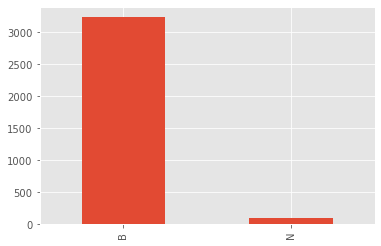

count     3335
unique       2
top          B
freq      3236
Name: third_party_2_country, dtype: object
*************************************************************************
third_party_2_vehicle_id
******* too many values to plot *******************
count                                            2252
unique                                           2224
top       NTA1OGYxYWY4Mzg4NjMzZjYwOWNhZGI3NWE3NWRjOWQ
freq                                               11
Name: third_party_2_vehicle_id, dtype: object
*************************************************************************
third_party_2_expert_id
******* too many values to plot *******************
count                                              20
unique                                             17
top       OTliOTAzYWU3YzljYzdkYmVmNzNmYWMyZjNjNzQ5OWE
freq                                                2
Name: third_party_2_expert_id, dtype: object
*************************************************************************

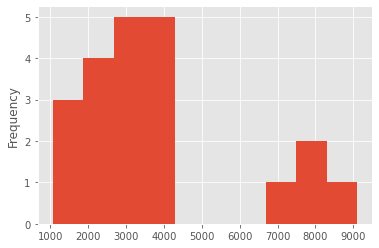

count      21.000000
mean     3823.809524
std      2348.262073
min      1070.000000
25%      2330.000000
50%      3290.000000
75%      3740.000000
max      9100.000000
Name: third_party_3_postal_code, dtype: float64
*************************************************************************
third_party_3_injured


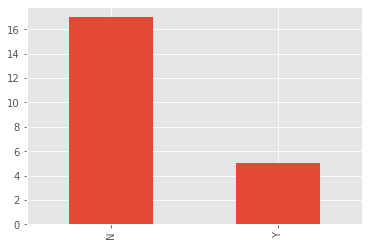

count     22
unique     2
top        N
freq      17
Name: third_party_3_injured, dtype: object
*************************************************************************
third_party_3_vehicle_type


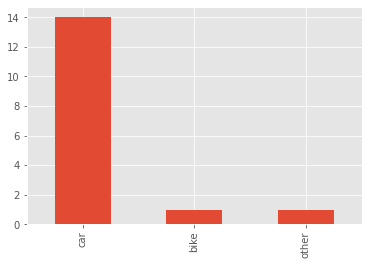

count      16
unique      3
top       car
freq       14
Name: third_party_3_vehicle_type, dtype: object
*************************************************************************
third_party_3_form


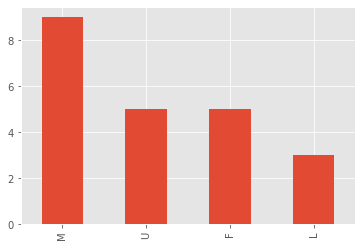

count     22
unique     4
top        M
freq       9
Name: third_party_3_form, dtype: object
*************************************************************************
third_party_3_year_birth


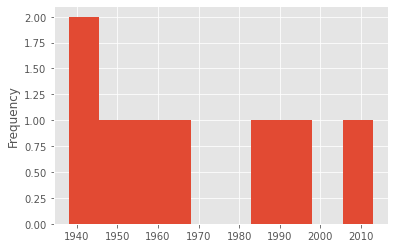

count       8.000000
mean     1968.250000
std        26.948363
min      1938.000000
25%      1949.500000
50%      1960.000000
75%      1987.250000
max      2013.000000
Name: third_party_3_year_birth, dtype: float64
*************************************************************************
third_party_3_country


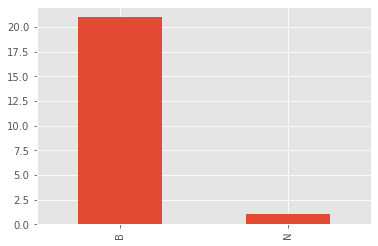

count     22
unique     2
top        B
freq      21
Name: third_party_3_country, dtype: object
*************************************************************************
third_party_3_vehicle_id
******* too many values to plot *******************
count                                              13
unique                                             13
top       YTVmYjllZTM3ZDZhYjc1MGMzNTViMWQzNDliZWNkN2U
freq                                                1
Name: third_party_3_vehicle_id, dtype: object
*************************************************************************
third_party_3_expert_id


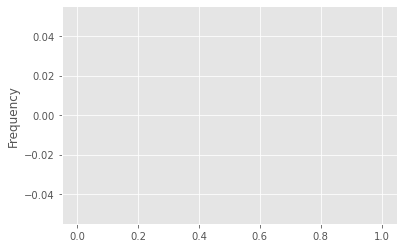

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: third_party_3_expert_id, dtype: float64
*************************************************************************
repair_id
******* too many values to plot *******************
count                                           20266
unique                                           4262
top       NzRjYTk0N2NiMTU4ZWYwMTdiM2Y1NTZiNjFiM2QxY2Y
freq                                              265
Name: repair_id, dtype: object
*************************************************************************
repair_postal_code


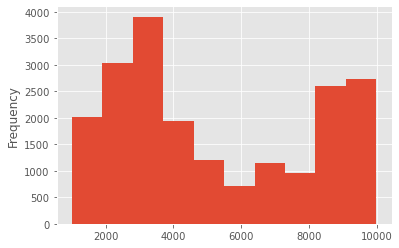

count    20248.000000
mean      5147.723726
std       2827.126359
min       1000.000000
25%       2800.000000
50%       4030.000000
75%       8400.000000
max       9991.000000
Name: repair_postal_code, dtype: float64
*************************************************************************
repair_form


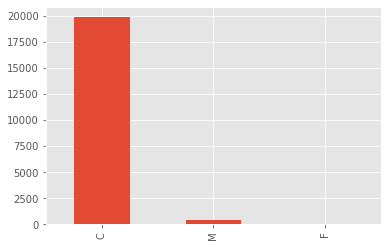

count     20266
unique        3
top           C
freq      19865
Name: repair_form, dtype: object
*************************************************************************
repair_year_birth


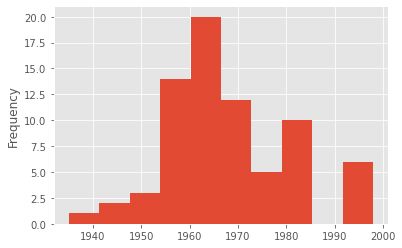

count      73.000000
mean     1968.191781
std        12.670676
min      1935.000000
25%      1960.000000
50%      1966.000000
75%      1977.000000
max      1998.000000
Name: repair_year_birth, dtype: float64
*************************************************************************
repair_country


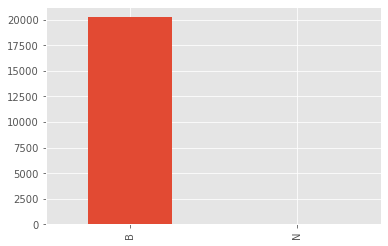

count     20266
unique        2
top           B
freq      20248
Name: repair_country, dtype: object
*************************************************************************
repair_sla


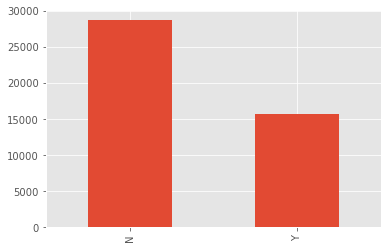

count     44370
unique        2
top           N
freq      28680
Name: repair_sla, dtype: object
*************************************************************************
policy_date_start


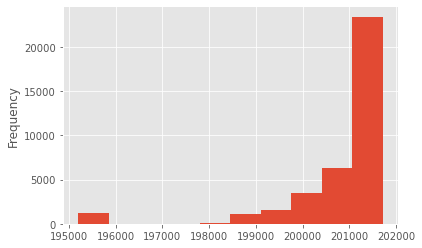

count     37085.000000
mean     200839.044870
std        1247.828323
min      195201.000000
25%      200707.000000
50%      201212.000000
75%      201508.000000
max      201712.000000
Name: policy_date_start, dtype: float64
*************************************************************************
policy_date_next_expiry


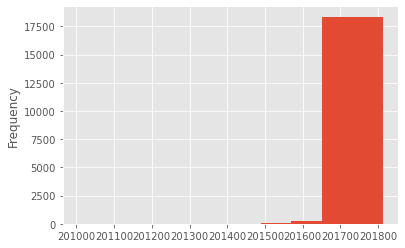

count     37085.000000
mean     201754.253337
std          52.895590
min      201005.000000
25%      201709.000000
50%      201712.000000
75%      201804.000000
max      201812.000000
Name: policy_date_next_expiry, dtype: float64
*************************************************************************
policy_date_last_renewed


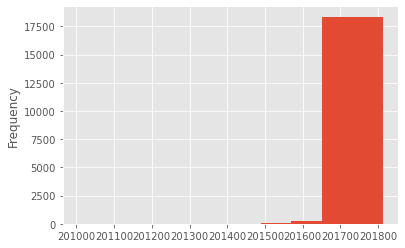

count     37085.000000
mean     201754.253337
std          52.895590
min      201005.000000
25%      201709.000000
50%      201712.000000
75%      201804.000000
max      201812.000000
Name: policy_date_last_renewed, dtype: float64
*************************************************************************
policy_num_changes


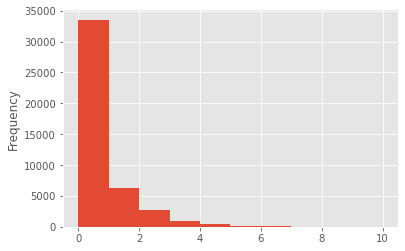

count    44370.000000
mean         0.423169
std          0.941272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: policy_num_changes, dtype: float64
*************************************************************************
policy_num_claims


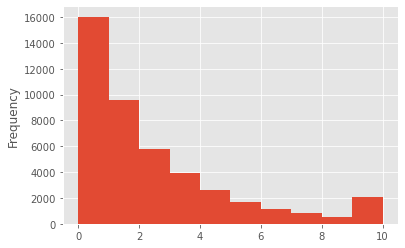

count    44370.000000
mean         2.029051
std          2.563549
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         10.000000
Name: policy_num_claims, dtype: float64
*************************************************************************
policy_premium_100


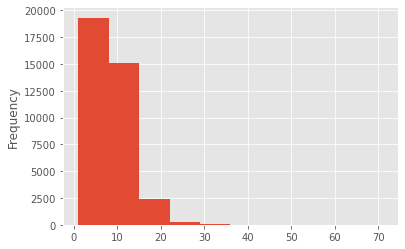

count    37078.000000
mean         7.945278
std          4.233610
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         71.000000
Name: policy_premium_100, dtype: float64
*************************************************************************
policy_coverage_1000


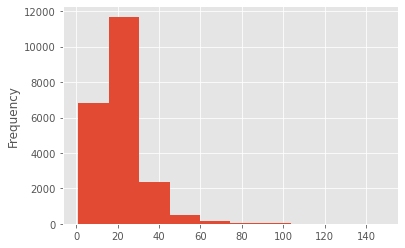

count    21638.000000
mean        21.552269
std         10.841057
min          1.000000
25%         14.000000
50%         19.000000
75%         26.000000
max        148.000000
Name: policy_coverage_1000, dtype: float64
*************************************************************************
policy_coverage_type
******* too many values to plot *******************
count          44370
unique            73
top       #000110000
freq            9366
Name: policy_coverage_type, dtype: object
*************************************************************************


In [11]:
for feature in df.columns:
    print(feature)
    try:
        df[feature].plot(kind="hist")
        plt.show()
        print(df[feature].describe())
    except TypeError:
        values = df[feature].value_counts()
        if len(values) < 10:
            values.plot(kind="bar")
            plt.show()
            print(df[feature].describe())
        else:
            print('******* too many values to plot *******************')
            print(df[feature].describe())
    print('*************************************************************************')

# Feature Engineering

In [12]:
# replace "," with "." and convert to numeric
df["claim_amount"] = pd.to_numeric(df["claim_amount"].str.replace(",", "."))

#### Mapování směrovacích čísel na kraje
klíč mapování podle https://en.wikipedia.org/wiki/List_of_postal_codes_in_Belgium

In [13]:
df["claim_postal_code"]

31604    9880
30616    2400
52575    2610
26786    9770
38639    4690
         ... 
28439    3190
7523     6200
38598    3550
54130    9850
46647    2180
Name: claim_postal_code, Length: 44370, dtype: int64

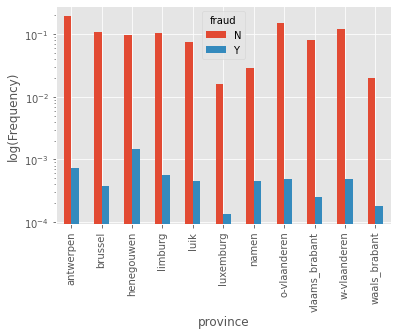

In [14]:
postal_bins = [999, 1299, 1499, 1999, 2999, 3499, 3999, 4999, 5999, 6599, 6999, 7999, 8999, 9999]
postal_label = ["brussel", "waals_brabant", "vlaams_brabant", 'antwerpen', 'vlaams_brabant', 'limburg', 
                'luik', 'namen', 'henegouwen', 'luxemburg', 'henegouwen', 'w-vlaanderen', 'o-vlaanderen']
df["province"] = pd.cut(df["claim_postal_code"], postal_bins, labels=postal_label, ordered=False)

pd.crosstab(df["province"], df["fraud"], normalize=True).plot.bar()
plt.yscale('log') #pro detailní zobrazení rozdílů v četnosti'
plt.ylabel('log(Frequency)')
plt.show()

#### Převod binárních kategoriálních features na číselné

In [15]:
def text_to_binary(col_name, bin_1, bin_0, df):
    return df[col_name].replace({bin_0:0, bin_1:1}, inplace=True)

In [16]:
# {"Y":1, "N":0}
text_to_binary("fraud","Y", "N", df)
text_to_binary("claim_liable", "Y", "N", df)
text_to_binary("claim_police", "Y", "N", df)
# {"P":1, "N":0}
text_to_binary("claim_alcohol", "P", "N", df)
# {"car":1, "van":0}
text_to_binary("claim_vehicle_type", "car", "van", df)
# {"M":1, "F":0}
text_to_binary("policy_holder_form", "M", "F", df)
# {"B":1, "N":0}
text_to_binary("policy_holder_country", "B", "N", df)

In [17]:
# 1: Dutch, 2: French -> 0: Dutch and 1: French
df["claim_language"] = df["claim_language"] - 1

Rozdělení claim_vehicle_power do 5 intervalů

In [18]:
df["vpower_buckets"] = pd.qcut(df["claim_vehicle_power"], 5)

Konverze datumových features na pandas datetime

In [19]:
# format date
YYYYMMDD_date_columns = ["claim_date_registered",
                         "claim_date_occured"]
for i in YYYYMMDD_date_columns:
    df[i] = pd.to_datetime(df[i], format="%Y%m%d")

# remove extreme value
df["claim_vehicle_date_inuse"].replace(to_replace=270505.0, value=np.nan,
                                       inplace=True)

YYYYMM_columns = ["claim_vehicle_date_inuse",
                  "policy_date_start",
                  "policy_date_next_expiry",
                  "policy_date_last_renewed"]
for i in YYYYMM_columns:
    df[i] = pd.to_datetime(df[i], format="%Y%m")

#### One Hot Encoding kategoriálních features s více hodnotami pomocí funkce get_dummies

In [20]:
cols = ['claim_cause', 'vpower_buckets', 'province']
df = pd.get_dummies(df, columns=cols)

#### Feature engineering nových sloupců:
Počet opakování žádostí pro dané vozidlo, pojištěnce, 3. strany atd.

In [21]:
df['claim_vehicle_id_count'] = df.groupby(by='claim_vehicle_id')['claim_id'].transform('count')
df['policy_holder_id_count'] = df.groupby(by='policy_holder_id')['claim_id'].transform('count')
df['driver_id_count'] = df.groupby(by='driver_id')['claim_id'].transform('count')
df['driver_vehicle_id_count'] = df.groupby(by='driver_vehicle_id')['claim_id'].transform('count')
df['third_party_1_id_count'] = df.groupby(by='third_party_1_id')['claim_id'].transform('count')
df['third_party_1_vehicle_id_count'] = df.groupby(by='third_party_1_vehicle_id')['claim_id'].transform('count')

df['claim_vehicle_id_count'].fillna(0, inplace=True)
df['policy_holder_id_count'].fillna(0, inplace=True)
df['driver_id_count'].fillna(0, inplace=True)
df['driver_vehicle_id_count'].fillna(0, inplace=True)
df['third_party_1_id_count'].fillna(0, inplace=True)
df['third_party_1_vehicle_id_count'].fillna(0, inplace=True)

Věk pojištěnce v datumu nehody

In [22]:
df['policy_holder_age'] = df["claim_date_occured"].dt.year - df["policy_holder_year_birth"]

## Odstranění nepoužitých features

Některé features byly odstraněny metodou sledování poklesu hodnot evaluačních metrik

Další důvody k odstranění:
- příliš mnoho chybějících hodnot
- příliš mnoho různých hodnot atributu
- jedná se o ID
- redukce komplexity, snaha o ponechání relevantních atributů

In [23]:
drop_features = [
"claim_postal_code",  #  přidáno jako kraj
"claim_vehicle_brand", # příliš mnoho různých hodnot
"claim_alcohol", # příliš mnoho chybějících hodnot
"claim_time_occured",
"claim_vehicle_cyl",
"claim_vehicle_load",
"claim_vehicle_fuel_type",
"policy_holder_postal_code",  
"policy_holder_year_birth",  # holder age --> přidáno
"third_party_1_postal_code",
"third_party_1_injured",
"third_party_1_vehicle_type",
"third_party_1_form",
"claim_vehicle_power", # přidáno (feature engineering)
"third_party_1_year_birth",
"third_party_1_country",
"repair_postal_code",
"repair_form",
"repair_year_birth",
"repair_country",
"repair_sla",
"policy_coverage_type",
"driver_postal_code",
"driver_form",
"driver_year_birth",
"driver_country",
"driver_injured",
"claim_amount" # odebráno kvůli nižší výkonosti modelu
]

drop_dates = [
"claim_date_registered",
"claim_date_occured",
"claim_vehicle_date_inuse",
"policy_date_start",
"policy_date_next_expiry",
"policy_date_last_renewed"
]

# smazání všech id sloupců
drop_id = [
"claim_vehicle_id",
"claim_id",
"policy_holder_id",
"policy_holder_expert_id",
"driver_id",
"driver_expert_id",
"driver_vehicle_id",
"third_party_1_id",
"third_party_1_vehicle_id",
"third_party_1_expert_id",
"third_party_3_expert_id",
"third_party_1_postal_code",
"third_party_1_injured", 
"third_party_1_vehicle_type", 
"third_party_1_form",         
"third_party_1_year_birth",   
"third_party_1_country",      
"third_party_1_vehicle_id",   
"third_party_1_expert_id",    
"third_party_2_id",           
"third_party_2_postal_code",  
"third_party_2_injured",      
"third_party_2_vehicle_type",  
"third_party_2_form",          
"third_party_2_year_birth",    
"third_party_2_country",       
"third_party_2_vehicle_id",  
"third_party_2_expert_id",   
"third_party_3_id",          
"third_party_3_postal_code", 
"third_party_3_injured",     
"third_party_3_vehicle_type",
"third_party_3_form",        
"third_party_3_year_birth",
"third_party_3_country",
"third_party_3_vehicle_id", 
"third_party_3_expert_id",
"repair_id"
]

df.drop(columns=drop_features + drop_dates + drop_id, inplace=True)

# vymazání všech ostatních sloupců s více než 50 000 chybějících hodnot (>90%)
missing_over_90prct = df.isna().sum().index[np.where(df.isna().sum() > 50000)]
df.drop(columns=missing_over_90prct, inplace=True)

# Train test split

In [24]:
X = df.iloc[:,1:]
y = df["fraud"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=96,stratify=y)

### Missing Values Imputation

Průměr pro numerical variables, modus pro categorical variables

In [26]:
# mode
train_lang_mode = X_train["claim_language"].mode()[0]
train_vtype_mode = X_train["claim_vehicle_type"].mode()[0]

# mean
train_premium_mean = X_train["policy_premium_100"].mean()
train_coverage_mean = X_train["policy_coverage_1000"].mean()
train_policy_holder_mean_age = X_train["policy_holder_age"].mean()

# mode
X_train["claim_language"].fillna(train_lang_mode, inplace=True)
X_test["claim_language"].fillna(train_lang_mode, inplace=True)
X_train["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)
X_test["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)

# mean
X_train["policy_premium_100"].fillna(train_premium_mean, inplace=True)
X_test["policy_premium_100"].fillna(train_premium_mean, inplace=True)
X_train["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
X_test["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
X_train["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)
X_test["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)

Kontrola výskytu chybějících hodnot obou datasetů

In [27]:
X_train.isna().sum()

claim_liable                      0
claim_num_injured                 0
claim_num_third_parties           0
claim_num_vehicles                0
claim_police                      0
claim_language                    0
claim_vehicle_type                0
policy_holder_form                0
policy_holder_country             0
policy_num_changes                0
policy_num_claims                 0
policy_premium_100                0
policy_coverage_1000              0
claim_cause_animal                0
claim_cause_fire                  0
claim_cause_other                 0
claim_cause_theft                 0
claim_cause_traffic accident      0
claim_cause_vandalism             0
claim_cause_weather               0
claim_cause_windows               0
vpower_buckets_(-0.001, 55.0]     0
vpower_buckets_(55.0, 66.0]       0
vpower_buckets_(66.0, 81.0]       0
vpower_buckets_(81.0, 100.0]      0
vpower_buckets_(100.0, 395.0]     0
province_antwerpen                0
province_brussel            

In [28]:
X_test.isna().sum()

claim_liable                      0
claim_num_injured                 0
claim_num_third_parties           0
claim_num_vehicles                0
claim_police                      0
claim_language                    0
claim_vehicle_type                0
policy_holder_form                0
policy_holder_country             0
policy_num_changes                0
policy_num_claims                 0
policy_premium_100                0
policy_coverage_1000              0
claim_cause_animal                0
claim_cause_fire                  0
claim_cause_other                 0
claim_cause_theft                 0
claim_cause_traffic accident      0
claim_cause_vandalism             0
claim_cause_weather               0
claim_cause_windows               0
vpower_buckets_(-0.001, 55.0]     0
vpower_buckets_(55.0, 66.0]       0
vpower_buckets_(66.0, 81.0]       0
vpower_buckets_(81.0, 100.0]      0
vpower_buckets_(100.0, 395.0]     0
province_antwerpen                0
province_brussel            

### Feature standardization

In [29]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# 1. Base Logistic Regression model - 'off the shelf'

In [30]:
lr = LogisticRegression(max_iter=500,random_state=96)
lr.fit(X_train_sc, y_train)

LogisticRegression(max_iter=500, random_state=96)

In [31]:
lr_predictions = lr.predict(X_test_sc)

### Model validation

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


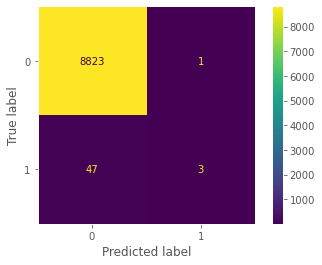

In [32]:
plot_confusion_matrix(lr, X_test_sc, y_test)
plt.grid(False)
plt.show()

#### Potvrzuje očekávaný problém s nevyváženými daty - FP: 47 vs TP: 3, bude potřeba oversampling nebo undersampling trénovacího datasetu.

Accuracy zde nemá objektivní vypovídající hodnotu - 99.5% dat je v cílové skupině negative -> Accuracy bude 99% i při predikci cílové proměnné pouze jako negativní.

#### V našem případě bude klíčovou metrikou recall (preference FP chyby (=fraudulent) proti FN (non-fraudulent)
zdroj: https://datascience.stackexchange.com/questions/30881/when-is-precision-more-important-over-recall

Recall:

In [34]:
recall_score(y_test, lr_predictions, average='macro')

0.5299433363553944

ROC curve:

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


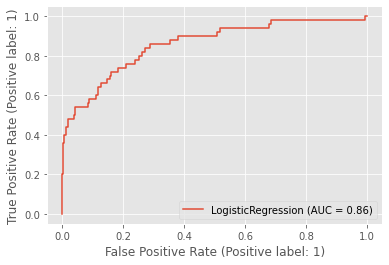

In [37]:
plot_roc_curve(lr, X_test_sc, y_test)

In [38]:
lr_report = classification_report(y_test, lr_predictions)

In [39]:
print(lr_report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8824
           1       0.75      0.06      0.11        50

    accuracy                           0.99      8874
   macro avg       0.87      0.53      0.55      8874
weighted avg       0.99      0.99      0.99      8874



# 2. Logistic Regression model - SMOTE

#### Použití SMOTE techniky pro balancování target labelu

In [54]:
over = SMOTE(sampling_strategy=0.2,random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5,random_state=96)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [55]:
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_sc, y_train)

#### Porovnání zastoupení cílové třídy před SMOTE a undersamplingem vs. po SMOTE a undersamplingu:

In [56]:
# before SMOTE and undersampling
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")
print("*********************************************************")

# after SMOTE and undersampling
neg_length = len(y_train_resampled) - y_train_resampled.sum()
pos_length = y_train_resampled.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")

Majority class (0): 35297
Minority class (1): 199
ratio: 0.5640000000000001%
*********************************************************
Majority class (0): 14118
Minority class (1): 7059
ratio: 50.0%


In [57]:
lr_smote = LogisticRegression(max_iter=500, random_state=42)
lr_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=500, random_state=42)

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


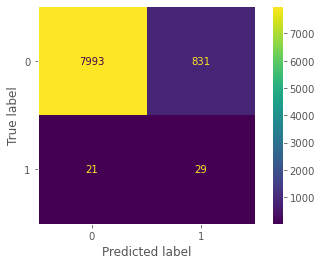

In [58]:
plot_confusion_matrix(lr_smote, X_test_sc, y_test)
plt.grid(False)
plt.show()

Nyní už model lépe predikuje TP oproti základní logistické regresi bez balancování datasetu

In [59]:
lr_smote_predictions = lr_smote.predict(X_test_sc)

Recall:

In [60]:
recall_score(y_test, lr_smote_predictions, average='macro')

0.7429125113327288

ROC curve

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


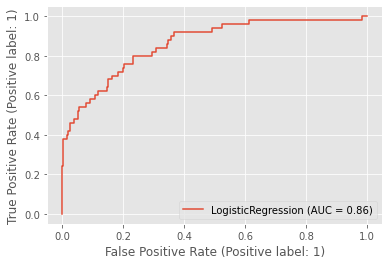

In [62]:
plot_roc_curve(lr_smote, X_test_sc, y_test)

In [63]:
lr_smote_report = classification_report(y_test, lr_smote_predictions)

In [64]:
print(lr_smote_report)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      8824
           1       0.03      0.58      0.06        50

    accuracy                           0.90      8874
   macro avg       0.52      0.74      0.51      8874
weighted avg       0.99      0.90      0.94      8874



# 3. Random Forest - SMOTE sampling

In [65]:
over_rf = SMOTE(sampling_strategy=0.4,random_state=42)
under_rf = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
steps_rf = [('o', over_rf), ('u', under_rf)]
pipeline_rf = Pipeline(steps=steps_rf)

In [66]:
X_train_rf, y_train_rf = pipeline_rf.fit_resample(X_train_sc, y_train)

#### Porovnání zastoupení cílové třídy před SMOTE a undersamplingem vs. po SMOTE a undersamplingu:

In [67]:
# before SMOTE and undersampling
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")
print("*********************************************************")
# after SMOTE and undersampling
neg_length = len(y_train_rf) - y_train_rf.sum()
pos_length = y_train_rf.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")

Majority class (0): 35297
Minority class (1): 199
ratio: 0.5640000000000001%
*********************************************************
Majority class (0): 23530
Minority class (1): 14118
ratio: 60.0%


Argument `class_weight='balanced_subsample'` použitý pro automatické přiřazení vah hodnotám cílové proměnné

In [68]:
rf_smote = RandomForestClassifier(n_estimators=1000, max_depth=20, class_weight='balanced_subsample', random_state=9, n_jobs=-1)

### Hyperparameter tuning pomocí Grid Search

In [69]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

#### !!! Gridsearch kvůli dlouhému výpočtu zakomentován - byly použity hyperparametry z jeho výstupu viz dále

In [71]:
#CV_rfc = GridSearchCV(estimator=rf_smote, param_grid=param_grid, cv=5)
#CV_rfc.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              max_depth=20, n_estimators=1000,
                                              n_jobs=-1, random_state=9),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [78]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

#### Random Forest Classifier model s parametry dle grid search

In [73]:
rf_optimal = RandomForestClassifier(random_state=26, max_features='auto', n_estimators= 500, max_depth=8, criterion='gini')

In [74]:
rf_optimal.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=8, n_estimators=500, random_state=26)

In [75]:
rf_predictions = rf_optimal.predict(X_test_sc)

#### Model Validation

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


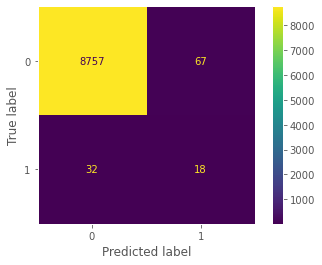

In [76]:
plot_confusion_matrix(rf_optimal, X_test_sc, y_test)
plt.grid(False)
plt.show()

Recall:

In [83]:
recall_score(y_test, rf_predictions, average='macro')

0.6762035358114233

ROC curve:

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


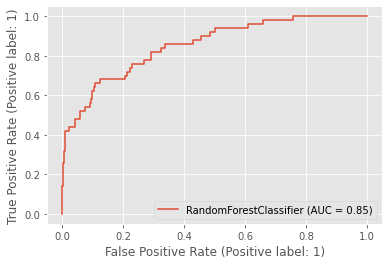

In [85]:
plot_roc_curve(rf_optimal, X_test_sc, y_test)

In [86]:
rf_report = classification_report(y_test, rf_predictions)

In [87]:
print(rf_report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8824
           1       0.21      0.36      0.27        50

    accuracy                           0.99      8874
   macro avg       0.60      0.68      0.63      8874
weighted avg       0.99      0.99      0.99      8874



# 4. Balanced Random Forest

In [89]:
over_brf = SMOTE(sampling_strategy=0.4,random_state=97)
steps_brf = [('o', over_brf)]
pipeline_brf = Pipeline(steps=steps_brf)

In [90]:
X_train_brf, y_train_brf = pipeline_brf.fit_resample(X_train_sc, y_train)

#### Porovnání zastoupení cílové třídy před SMOTE a undersamplingem vs. po SMOTE a undersamplingu:

In [91]:
# before SMOTE and undersampling
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")
print("*********************************************************")
# after SMOTE and undersampling
neg_length = len(y_train_brf) - y_train_brf.sum()
pos_length = y_train_brf.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")

Majority class (0): 35297
Minority class (1): 199
ratio: 0.5640000000000001%
*********************************************************
Majority class (0): 35297
Minority class (1): 14118
ratio: 39.998%


Argument `class_weight='balanced_subsample'` použitý pro automatické přiřazení vah hodnotám cílové proměnné

In [92]:
brfc = BalancedRandomForestClassifier(n_estimators=10000, max_depth=5, random_state=9, 
                                      n_jobs=-1, class_weight="balanced_subsample")

In [93]:
brfc.fit(X_train_brf, y_train_brf)

BalancedRandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                               n_estimators=10000, n_jobs=-1, random_state=9)

### Hyperparameter tuning pomocí Grid Search

In [94]:
param_grid_brf = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

#### !!! Nespouštět GridSearch (dlouhý výpočet) - výstupní hodnoty použity pro hyperparameter tuning viz níže

In [96]:
#CV_brfc = GridSearchCV(estimator=brfc, param_grid=param_grid_brf, cv=5)
#CV_brfc.fit(X_train_brf, y_train_brf)

GridSearchCV(cv=5,
             estimator=BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                      max_depth=5,
                                                      n_estimators=10000,
                                                      n_jobs=-1,
                                                      random_state=9),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [97]:
CV_brfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

#### Balanced Random Forest Classifier s hyperparametry dle výsledků grid search

In [98]:
brf_optimal = BalancedRandomForestClassifier(random_state=26, max_features='auto', n_estimators= 500, max_depth=8, criterion='gini')

In [99]:
brf_optimal.fit(X_train_brf, y_train_brf)

BalancedRandomForestClassifier(max_depth=8, n_estimators=500, random_state=26)

In [100]:
brf_predictions = brf_optimal.predict(X_test_sc)

#### Model Validation

Confusion Matrix

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


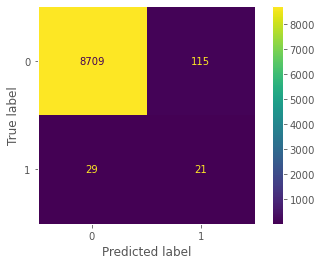

In [101]:
plot_confusion_matrix(brf_optimal, X_test_sc, y_test)
plt.grid(False)
plt.show()

Recall:

In [103]:
recall_score(y_test, brf_predictions, average='macro')

0.7034836808703536

ROC curve:

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


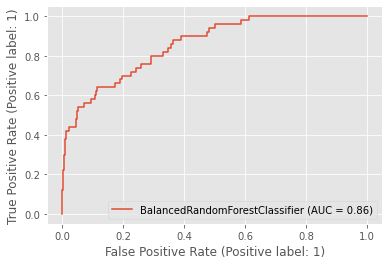

In [104]:
plot_roc_curve(brf_optimal, X_test_sc, y_test)

In [109]:
brf_report = classification_report(y_test, brf_predictions)

In [110]:
print(brf_report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8824
           1       0.16      0.42      0.23        50

    accuracy                           0.98      8874
   macro avg       0.58      0.70      0.61      8874
weighted avg       0.99      0.98      0.99      8874



# Finální Evaluace s pomocí hold-out setu (unseen data evaluation)

### Feature engineering - evaluation set

Nejprve je nezbytné provést stejné kroky pro feature engineering jako u trénovacího datasetu, ale izolovaně v rámci evaluačního setu. 

In [105]:
# replace "," with "." and convert to numeric
eval_set["claim_amount"] = pd.to_numeric(eval_set["claim_amount"].str.replace(",", "."))

In [106]:
eval_set["province"] = pd.cut(eval_set["claim_postal_code"], postal_bins, labels=postal_label, ordered=False)

In [107]:
# {"Y":1, "N":0}
text_to_binary("fraud","Y", "N", eval_set)
text_to_binary("claim_liable", "Y", "N", eval_set)
text_to_binary("claim_police", "Y", "N", eval_set)
# {"P":1, "N":0}
text_to_binary("claim_alcohol", "P", "N", eval_set)
# {"car":1, "van":0}
text_to_binary("claim_vehicle_type", "car", "van", eval_set)
# {"M":1, "F":0}
text_to_binary("policy_holder_form", "M", "F", eval_set)
# {"B":1, "N":0}
text_to_binary("policy_holder_country", "B", "N", eval_set)

In [108]:
eval_set["claim_language"] = eval_set["claim_language"] - 1

In [109]:
eval_set["vpower_buckets"] = pd.qcut(eval_set["claim_vehicle_power"], 5)

In [110]:
for i in YYYYMMDD_date_columns:
    eval_set[i] = pd.to_datetime(eval_set[i], format="%Y%m%d")

# remove extreme value
eval_set["claim_vehicle_date_inuse"].replace(to_replace=270505.0, value=np.nan,
                                       inplace=True)

for i in YYYYMM_columns:
    eval_set[i] = pd.to_datetime(eval_set[i], format="%Y%m")

In [111]:
cols = ['claim_cause', 'vpower_buckets', 'province']
eval_set = pd.get_dummies(eval_set, columns=cols)

In [112]:
eval_set['claim_vehicle_id_count'] = eval_set.groupby(by='claim_vehicle_id')['claim_id'].transform('count')
eval_set['policy_holder_id_count'] = eval_set.groupby(by='policy_holder_id')['claim_id'].transform('count')
eval_set['driver_id_count'] = eval_set.groupby(by='driver_id')['claim_id'].transform('count')
eval_set['driver_vehicle_id_count'] = eval_set.groupby(by='driver_vehicle_id')['claim_id'].transform('count')
eval_set['third_party_1_id_count'] = eval_set.groupby(by='third_party_1_id')['claim_id'].transform('count')
eval_set['third_party_1_vehicle_id_count'] = eval_set.groupby(by='third_party_1_vehicle_id')['claim_id'].transform('count')

eval_set['claim_vehicle_id_count'].fillna(0, inplace=True)
eval_set['policy_holder_id_count'].fillna(0, inplace=True)
eval_set['driver_id_count'].fillna(0, inplace=True)
eval_set['driver_vehicle_id_count'].fillna(0, inplace=True)
eval_set['third_party_1_id_count'].fillna(0, inplace=True)
eval_set['third_party_1_vehicle_id_count'].fillna(0, inplace=True)

In [113]:
eval_set['policy_holder_age'] = eval_set["claim_date_occured"].dt.year - eval_set["policy_holder_year_birth"]

In [114]:
eval_set.drop(columns=drop_features + drop_dates + drop_id, inplace=True)

# exclude columns with over 50k missing values (i.e. over 90%)
missing_over_90prct = eval_set.isna().sum().index[np.where(eval_set.isna().sum() > 50000)]
eval_set.drop(columns=missing_over_90prct, inplace=True)

In [115]:
# mode
eval_lang_mode = eval_set["claim_language"].mode()[0]
eval_vtype_mode = eval_set["claim_vehicle_type"].mode()[0]

# mean
eval_premium_mean = eval_set["policy_premium_100"].mean()
eval_coverage_mean = eval_set["policy_coverage_1000"].mean()
eval_policy_holder_mean_age = eval_set["policy_holder_age"].mean()

# mode
eval_set["claim_language"].fillna(eval_lang_mode, inplace=True)
eval_set["claim_vehicle_type"].fillna(eval_vtype_mode, inplace=True)

# mean
eval_set["policy_premium_100"].fillna(eval_premium_mean, inplace=True)
eval_set["policy_coverage_1000"].fillna(eval_coverage_mean, inplace=True)
eval_set["policy_holder_age"].fillna(eval_policy_holder_mean_age, inplace=True)

In [116]:
X_eval = eval_set.iloc[:,1:]
y_eval = eval_set["fraud"]
X_eval_sc = scaler.transform(X_eval)

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- vpower_buckets_(100.0, 426.0]
- vpower_buckets_(66.0, 80.0]
- vpower_buckets_(80.0, 100.0]
Feature names seen at fit time, yet now missing:
- vpower_buckets_(100.0, 395.0]
- vpower_buckets_(66.0, 81.0]
- vpower_buckets_(81.0, 100.0]

  warnings.warn(message, FutureWarning)


## Predikce na evaluačním setu

In [117]:
eval_lr_predictions = lr.predict(X_eval_sc)
eval_lr_smote_predictions = lr_smote.predict(X_eval_sc)
eval_rf_predictions = rf_optimal.predict(X_eval_sc)
eval_brf_predictions = brf_optimal.predict(X_eval_sc)

## Evaluace

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


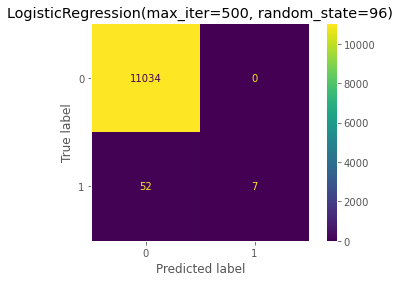

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


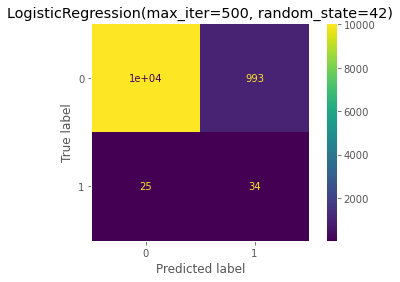

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


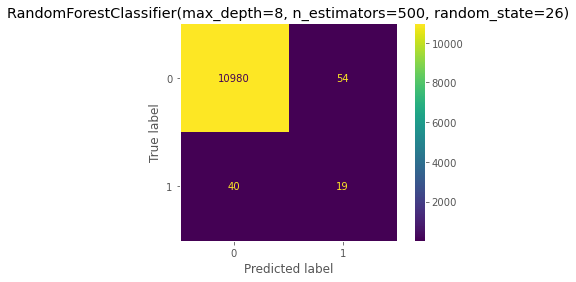

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


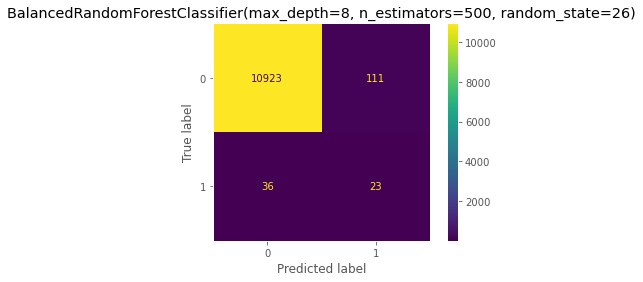

In [127]:
classifiers =  [lr,lr_smote,rf_optimal,brf_optimal]
for model in classifiers:
    plot_confusion_matrix(model, X_eval_sc, y_eval)
    plt.title(model)
    plt.grid(False)
    plt.show()

/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/Pavel/opt/anaconda3/envs/python_assignment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in

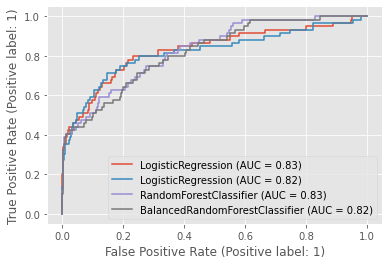

In [163]:
disp = plot_roc_curve(lr, X_eval_sc, y_eval)

plot_roc_curve(lr_smote, X_eval_sc, y_eval, ax=disp.ax_)
plot_roc_curve(rf_optimal, X_eval_sc, y_eval, ax=disp.ax_)
plot_roc_curve(brf_optimal, X_eval_sc, y_eval, ax=disp.ax_)

In [164]:
eval_lr_report = classification_report(y_eval, eval_lr_predictions)
eval_lr_smote_report = classification_report(y_eval, eval_lr_smote_predictions)
eval_rf_report = classification_report(y_eval, eval_rf_predictions)
eval_brf_report = classification_report(y_eval, eval_brf_predictions)

results = {"LOGISTIC REGRESSION - BASE": eval_lr_report,
           "LOGISTIC REGRESSION - SMOTE": eval_lr_smote_report,
           "RANDOM FOREST - SMOTE": eval_rf_report,
           "BALANCED RANDOM FOREST": eval_brf_report}

In [165]:
for key in results:
    print(key, '\n', results[key], '\n ****************************************************\n')

LOGISTIC REGRESSION - BASE 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11034
           1       1.00      0.12      0.21        59

    accuracy                           1.00     11093
   macro avg       1.00      0.56      0.60     11093
weighted avg       1.00      1.00      0.99     11093
 
 ****************************************************

LOGISTIC REGRESSION - SMOTE 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     11034
           1       0.03      0.58      0.06        59

    accuracy                           0.91     11093
   macro avg       0.52      0.74      0.51     11093
weighted avg       0.99      0.91      0.95     11093
 
 ****************************************************

RANDOM FOREST - SMOTE 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11034
           1       0.26      0.32      0.2

Dle výsedků evaluace dosahuje nejvyšší recall hodnoty pro `fraud=1` model logistické regrese se SMOTE balancováním nevyváženého datasetu (`recall = 0.58`) AUC je u všech 4 modelů poměrně vyrovnaná. Nejstrmější růst ROC curve je u modelu SMOTE logistické regerse - jelikož se opět jedná o vyjádření recall (=sensitivity či TPR) vůči specificity (FPR). 
Random Forest se SMOTE balancováním má nejvyšší F1-score, precision a recall jsou u něj tedy nejlépe vyvážené.

Jak je patrné, accuracy je u všech modelů velice vysoká, jak již bylo zmíněno, v případě imbalanced klasifikace je její hodnota irelevantní pro evaluaci modelu.